# Diurnal Plots

Here, we plot diurnal figures for the factors to see whether or not they are, in fact, unique.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import numpy as np
import joblib
import os
from matplotlib.dates import date2num
from datetime import timedelta

mpl.rcParams['mathtext.default'] = 'regular'

sns.set("paper", "ticks", color_codes=True, palette='colorblind', font_scale=1.5)

%matplotlib inline

# Set the default paths
basepath = Path(os.path.dirname(os.path.realpath('__file__')))
datapath = basepath.parent.joinpath('data')

## Load the data

In [2]:
nmf = pd.read_feather(datapath.joinpath("output/tata2017015/nmf-tseries-results.feather")).set_index("index")

In [ ]:
def diurnal(data, **kwargs):
    """
    """
    cpy = data.copy()
    cpy["_time"] = cpy.index.map(lambda dt: dt.strftime("%H:%M"))
    
    stats = cpy.groupby("_time").describe()
    stats.index = stats.index.map(pd.to_datetime)
    
    # get the column names
    cols = stats.columns.get_level_values(0).unique().values
    
    with sns.axes_style(kwargs.pop('style', 'white')):
        fig, ax = plt.subplots(1, figsize=kwargs.pop('figsize', (10, 6)))
        
        for c in cols:
            ax.plot(stats.index, stats[c]['mean'], label=c, lw=5)
        
        ticks = ax.get_xticks()
        ax.set_xticks(np.linspace(date2num(stats.index[0]), date2num(stats.index[0] + timedelta(hours=24)), 5))
        ax.set_xticks(np.linspace(date2num(stats.index[0]), date2num(stats.index[0] + timedelta(hours=24)), 25), minor=True)

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%I:%M %p'))

        ax.set_xlim(stats.index[0], stats.index[-1])
        ax.set(yticks=[0, 0.5, 1, 1.5, 2, 2.5], yticklabels=["0", "", "1", "", "2", ""])
        ax.set_ylabel("Factor Signal", fontsize=28)
        ax.legend(loc='upper left')

        ax.grid(None, axis='x')

        ax.set_ylim(0, 2.5)
    
    return ax

## Compute the diurnal statistics

In [44]:
cpy = nmf[["Factor 1", "Factor 2", "Factor 3", "HOA/BBOA", "SVOOA", "LVOOA", "AC"]].resample('5min').mean().dropna(how='any')

cpy["_ts"] = cpy.index.map(lambda dt: dt.strftime("%H:%M"))

stats = cpy.groupby("_ts").describe()
stats.index = stats.index.map(pd.to_datetime)

## Plot the figure for 3 Factors

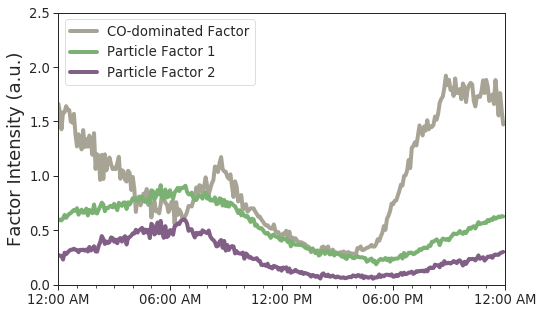

In [104]:
fig, ax = plt.subplots(1, figsize=(8, 5))

ax.plot(stats.index, stats["Factor 1"]["mean"], label="CO-dominated Factor", lw=4, color=sns.xkcd_rgb['greyish'])
ax.plot(stats.index, stats["Factor 2"]["mean"], label="Particle Factor 1", lw=4, color=sns.xkcd_rgb['faded green'])
ax.plot(stats.index, stats["Factor 3"]["mean"], label="Particle Factor 2", lw=4, color=sns.xkcd_rgb['dusty purple'])

ticks = ax.get_xticks()

ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18, 24]))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%I:%M %p"))
ax.set_xlim(ticks[0], ticks[-1])
ax.set_ylim(0, 2.5)
ax.set_ylabel("Factor Intensity (a.u.)", fontsize=18)

ax.legend(loc='upper left')

fig.savefig("NMF-diurnal.png", dpi=350)

## Plot the figure for 4 Factors

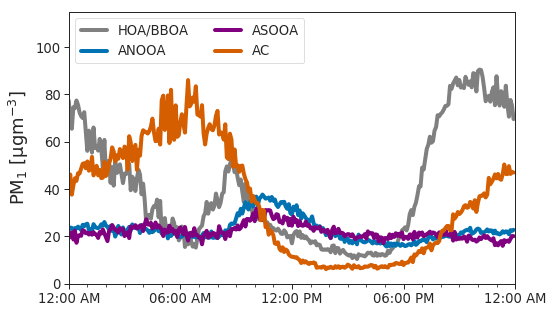

In [105]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

ax.plot(stats.index, stats["HOA/BBOA"]["mean"], label="HOA/BBOA", lw=4, color="gray")
ax.plot(stats.index, stats["SVOOA"]["mean"], label="SVOOA", lw=4, color="b")
ax.plot(stats.index, stats["LVOOA"]["mean"], label="LVOOA", lw=4, color="purple")
ax.plot(stats.index, stats["AC"]["mean"], label="AC", lw=4, color="r")


ticks = ax.get_xticks()

ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18, 24]))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%I:%M %p"))
ax.set_xlim(ticks[0], ticks[-1])
ax.set_ylim(0, 115)
ax.legend(["HOA/BBOA", "ANOOA", "ASOOA", "AC"], loc='upper left', ncol=2)
ax.set_ylabel("$PM_1$ [$\mu g m^{-3}$]", fontsize=18);

fig.savefig("PMF-diurnal.png", dpi=350)

## Plot the ratio of Particle Factor 1 to Particle Factor 2

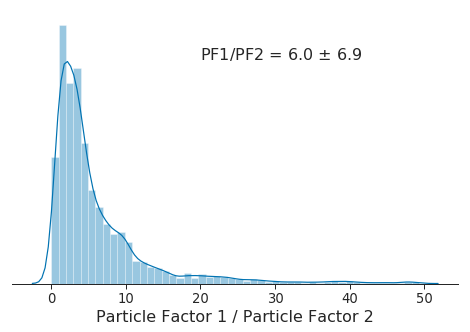

In [158]:
nmf[["Factor 2", "Factor 3"]]

nmf["ratio"] = nmf["Factor 2"] / nmf["Factor 3"]

ratio = nmf.query("ratio < 50").replace(np.inf, np.nan).dropna()["ratio"]

fig, ax = plt.subplots(1, figsize=(8, 5))

sns.distplot(ratio, ax=ax)

sns.despine(left=True)
plt.setp(ax, yticks=[])
ax.text(20, 0.15, "PF1/PF2 = {:.1f} $\pm$ {:.1f}".format(ratio.mean(), ratio.std()), fontsize=16)

ax.set_xlabel("Particle Factor 1 / Particle Factor 2", fontsize=16);

fig.savefig("factor-ratio.png", dpi=350)